In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sp_stats
import requests
from datetime import timedelta
import matplotlib.pyplot as plt
import time
import math

In [3]:
POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='USDT_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [4]:
class EntropyEstimatorLz:
    """
    Kontoyiannis' LZ entropy estimate, 2013 version (centered window). Inverse
    of the avg length of the shortest non-redundant substring. If non-redundant
    substrings are short, the text is highly entropic. window==None for
    expanding window, in which case
    len(msg) % 2 == 0
    If the end of msg is more relevant, try estimate_entropy(msg[::-1])
    """
    @classmethod
    def estimate_entropy(cls, *args, **kwargs):
        return cls.konto(*args, **kwargs)['h']

    @classmethod
    def konto(cls, msg, window=None):
        """
        :param msg:
        :param window:
        :return:
        """
        out = {'num': 0, 'sum': 0, 'sub_str': []}
        if not isinstance(msg, str):
            msg = ''.join(map(str, msg))

        if window is None:
            points = range(1, len(msg) // 2 + 1)

        else:
            window = min(window, len(msg) // 2)
            points = range(window, len(msg) - window + 1)

        for i in points:
            if window is None:
                l, msg_ = cls.match_length(msg, i, i)
                out['sum'] += math.log2(i + 1) / l

            else:
                l, msg_ = cls.match_length(msg, i, window)
                out['sum'] += math.log2(window + 1) / l

            out['sub_str'].append(msg_)
            out['num'] += 1

        out['h'] = (out['sum'] / out['num']) / math.log(2)
        out['r'] = 1 - out['h'] / math.log2(len(msg))  # redundancy, 0 <= r <= 1

        return out

    @staticmethod
    def match_length(msg, i, n):
        """
        Maximum matched length + 1, with overlap.
        i >= n & len(msg) >= i + n
        :param msg:
        :param i:
        :param n:
        :return:
        """
        sub_str = ''
        for l in range(n):
            msg1 = msg[i:i + l + 1]

            for j in range(i - n, i):
                msg0 = msg[j:j + l + 1]

                if msg1 == msg0:
                    sub_str = msg1
                    break  # search for higher l.

        return len(sub_str) + 1, sub_str  # matched length + 1


if __name__ == '__main__':
    # Messages produces entropies of 0.97 and 0.84 as highlighted in
    # "Advances in Financial Machine Learning" section 18.4
    for m in ('11100001', '01100001'):
        h = EntropyEstimatorLz.estimate_entropy(m) * math.log(2)
print('message: %s, entropy: %.2f' % (m, h))

message: 01100001, entropy: 0.84


In [5]:
def plugIn(msg, w):
    # Compute plug-in (ML) entropy rate
    pmf = pmf1(msg, w)
    out = - sum([pmf[i] * np.log2(pmf[i]) for i in pmf]) / w
    return out, pmf

def pmf1(msg, w):
    # Compute the prob mass function for a 1D discrete RV
    # len(msg)-w occurances
    lib = {}
    if not isinstance(msg, str): msg = ''.join(map(str, msg))
    for i in range(w, len(msg)):
        msg_ = msg[i-w: i]
        if msg_ not in lib: 
            lib[msg_] = [i-w]
        else: 
            lib[msg_] = lib[msg_] + [i-w]
    pmf = float(len(msg) - w)
    pmf = {i: len(lib[i])/pmf for i in lib}
    return pmf

In [6]:
def segment(total):
    current_seg = []
    len_seg = len(total)//1000
    for item in total:
        if len(current_seg) < len_seg:
            current_seg.append(item)
            continue
        yield current_seg
        current_seg = []

In [7]:
df = get_ohlcv_poloniex(pair='USDT_ETH', start=0, end=9999999999, period=900)
df['ret'] = df['weightedAverage'].pct_change()
df = df[df['ret'] != 0]
df = df[df['ret'] != np.inf]
df = df[df['ret'].notnull()]
df['binary'] = df.apply(lambda row: int(row['ret']*(row['ret']-1) > 0), axis = 1)

In [8]:
partitions = segment(df['binary'])
num_segments = len(df['binary'])//1000
print(num_segments)

97


Plug in entropies


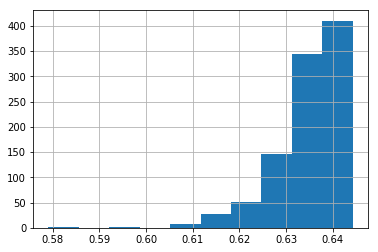

In [9]:
print("Plug in entropies")
results = pd.DataFrame()
results['plug-in'] = [plugIn(part, 10)[0] for part in partitions]

results['plug-in'].hist()

In [10]:
print("Kontoyiannis’ method entropies using window size of 100")
partitions = segment(df['binary'])
# for part in partitions:
#     print(part)
#     print("binary: " + str(EntropyEstimatorLz.estimate_entropy(part, window=100)))
results['kontoyiannis'] = [EntropyEstimatorLz.estimate_entropy(part, window=100) for part in partitions]

Kontoyiannis’ method entropies using window size of 100


In [11]:
print(results['kontoyiannis'].corr(results['plug-in']))

0.1402793149629998


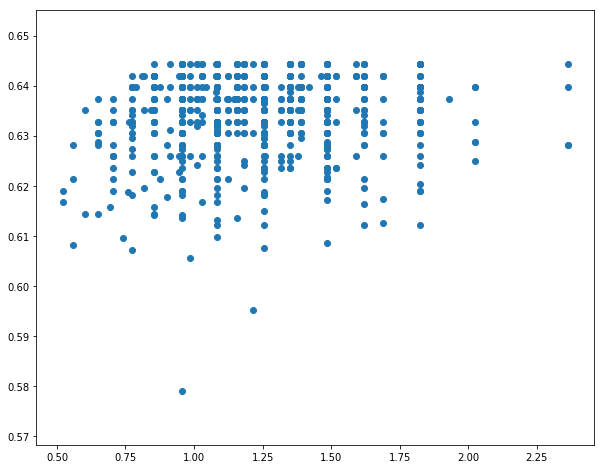

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(results['kontoyiannis'], results['plug-in'])